To test if a general purpose sentiment analysis model can be used to predict the sentiment of political tweets.

In [1]:
# Define Model
import torch
import torch.nn as nn
from tqdm import tqdm
import pandas as pd
from transformers import RobertaModel
from transformers import RobertaTokenizer
from roberta_classifer import RobertaClassifier
    
# Instantiate the model
model = RobertaClassifier()

# Load pre-trained weights
model.load_state_dict(torch.load('model_weights.pt'))

model.to('cuda')
# Set the model to evaluation mode
model.eval()

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaClassifier(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Laye

In [2]:
import os

folder_path = 'data'

file_list = os.listdir(folder_path)

datasets = []

for file_name in file_list:
    file_path = os.path.join(folder_path, file_name)
    if os.path.isfile(file_path):
        print(f'Loading : {file_name}')
        datasets.append(pd.read_csv(file_path))

#Combine the datasets
dataset = pd.concat(datasets, ignore_index=True)
#Shuffle the dataset
dataset = dataset.sample(frac=1).reset_index(drop=True)

#Remove the unnecessary columns
dataset = dataset.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
dataset.dropna(subset=['text'], inplace=True)

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(dataset['text'], dataset['label'], test_size=0.2, random_state=42)
x_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)



Loading : against-posts.csv
Loading : against1-posts.csv
Loading : neutral.csv
Loading : neutral_data1.csv
Loading : pro-posts.csv
Loading : pro1-posts.csv


# Train

In [3]:
train_inputs, train_masks = model.preprocess_for_roberta(x_train)
print('Done training masking.')
test_inputs, test_masks = model.preprocess_for_roberta(x_test)
print('Done testing masking.')


100%|██████████| 7550/7550 [00:05<00:00, 1371.30it/s]


Done training masking.


100%|██████████| 1888/1888 [00:01<00:00, 1133.15it/s]


Done testing masking.


In [4]:
# Batch Size
batch_size = 13

# Turn labels into a Tensor
y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)

# Create the DataLoader for our training set
train_dataloader = model.create_train_dataloader(train_inputs, train_masks, y_train, batch_size)

# Create the DataLoader for our testing set
test_dataloader = model.create_test_dataloader(test_inputs, test_masks, batch_size)




## Start Training Loop

In [5]:
import time
import random
import gc
import numpy as np
# Loss
loss_fn = nn.CrossEntropyLoss()

random.seed(20)
np.random.seed(20)
torch.manual_seed(20)
torch.cuda.manual_seed_all(20)

def train(roberta_classifier, optimizer, scheduler, epochs=4):
    loss_hist = []
    model.train()
    for epoch in tqdm(range(epochs)):
        
        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        roberta_classifier.train()

        progress_bar = tqdm(total=len(train_dataloader), desc=f'Epoch {epoch+1}', position=0)
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1

            # Load batch to GPU
            batch_inputs, batch_masks, batch_labels = tuple(t.to('cuda') for t in batch)

            # Zero out gradients
            roberta_classifier.zero_grad()

            # Perform a forward pass.
            logits = roberta_classifier(batch_inputs, batch_masks)

            # Compute loss
            loss = loss_fn(logits, batch_labels)
            batch_loss += loss.item()
            total_loss += loss.item()
            
            # Perform a backward pass
            loss.backward()

            
            # Clip norm
            torch.nn.utils.clip_grad_norm_(roberta_classifier.parameters(), 1.0)

            # step optimizer, update params
            optimizer.step()
            scheduler.step()

            # Progress update every 20 batches.
            # if step % 20 == 0 and not step == 0:
            #     # Calculate elapsed time in minutes.
            #     elapsed = time.time() - t0_batch

            #     # Print training results
            #     print(f"{epoch:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {elapsed:^9.2f}")

            #     # Reset batch tracking variables
            #     batch_loss, batch_counts = 0, 0
            #     t0_batch = time.time()
            progress_bar.update(1)
            progress_bar.set_postfix({'Elapsed': time.time() - t0_epoch, 'Loss': total_loss / batch_counts})
        
        # Calculate the average loss
        avg_train_loss = total_loss / len(train_dataloader)
        loss_hist.append(avg_train_loss)
        print("-"*100)



In [6]:
import gc
gc.collect()
torch.cuda.empty_cache()

num_epochs = 2


optimizer = model.get_optimizer(lr=5e-5)
train(model, optimizer, model.get_scheduler(optimizer, train_dataloader, epochs=num_epochs), epochs=num_epochs)

 50%|█████     | 1/2 [04:02<04:02, 242.91s/it],  2.54it/s, Elapsed=243, Loss=0.307] 

----------------------------------------------------------------------------------------------------


Epoch 2: 100%|██████████| 581/581 [04:04<00:00,  2.38it/s, Elapsed=245, Loss=0.107]

----------------------------------------------------------------------------------------------------


In [7]:
(y_train == 0).sum(), (y_train == 1).sum(), (y_train == 2).sum()

(tensor(2548), tensor(2612), tensor(2390))

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.preprocessing import label_binarize

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC (multiclass ROC)
    - Create and plot the confusion matrix as percentages
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), num_classes)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    num_classes = probs.shape[1]
    
    # One-hot encode the true labels
    y_binary = label_binarize(y_true, classes=np.arange(num_classes))
    
    # Initialize dictionaries to store ROC curves and AUC values for each class
    roc_curves = {}
    auc_values = {}
    
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_binary[:, i], probs[:, i])
        roc_auc = auc(fpr, tpr)
        auc_values[i] = roc_auc
        
        # Plot ROC curve for each class
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')
    
    # Get accuracy over the test set
    y_pred = np.argmax(probs, axis=1)
    accuracy = accuracy_score(y_true, y_pred)
    
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.annotate(f'Acc: {accuracy*100:.2f}%', xy=(0.8, 0.2))
    plt.show()
    
    # Create and plot the confusion matrix as percentages
    cm = confusion_matrix(y_true, y_pred)
    class_names = np.arange(num_classes)  # Replace with your class labels
    
    # Calculate percentages for each cell
    cm_percent = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100
    
    confusion_df = pd.DataFrame(cm_percent, index=class_names, columns=class_names)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_df, annot=True, cmap='Blues', fmt='.2f', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix (Percentages)')
    plt.show()
    
    return auc_values, accuracy

# Example usage:
# Assuming 'probs' contains the predicted probabilities with shape (len(y_test), num_classes)
# and 'y_test' contains the true labels
# auc_values, accuracy = evaluate_roc(probs, y_test)


def evaluate_roc_binary(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    figure = plt.figure()
    plt.title(f'Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.annotate(f'Acc: {accuracy*100:.2f}%', xy=(0.8, 0.2))
    plt.show()
    return figure

In [2]:
import torch.nn.functional as F

def roberta_predict(loader):
    """Perform a forward pass on the trained Roberta model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.

    all_logits = []
    model.eval()
    # For each batch in our test set...
    for batch in loader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to('cuda') for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate confidence
    probs = F.softmax(all_logits, dim=1).cpu()

    return probs


In [10]:
from sklearn.metrics import f1_score
def evaluate_f1(preds, truth, threshold=0.5):
    # Convert the input tensors to NumPy arrays for consistency
    preds = preds.cpu().numpy()
    truth = truth.cpu().numpy()

    # Apply the threshold to convert probabilities to binary labels
    binary_preds = (preds > threshold).astype(int)

    # Calculate the F1 score for each label and average them (macro-average)
    f1_scores = f1_score(truth, binary_preds, average='macro')

    # Calculate the F1 score for each label individually
    f1_scores_per_label = f1_score(truth, binary_preds, average=None)

    # Plot the F1 scores for each label
    labels = np.arange(len(f1_scores_per_label))
    plt.figure(figsize=(10, 6))
    plt.bar(labels, f1_scores_per_label)
    plt.xticks(labels)
    plt.xlabel('Label Index')
    plt.ylabel('F1 Score')
    plt.title('F1 Score per Label')
    plt.show()
    
    return f1_scores, f1_scores_per_label

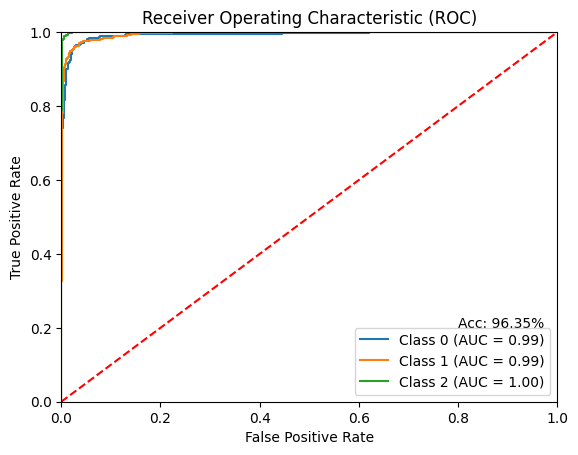

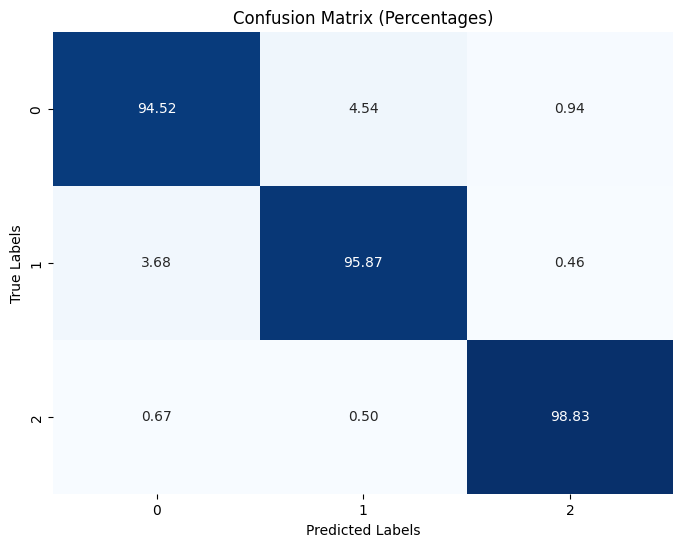

({0: 0.9927779469271818, 1: 0.9947411820870352, 2: 0.9996194963326199},
 0.9634533898305084)

In [11]:
preds = roberta_predict(test_dataloader)
evaluate_roc(preds, y_test)


In [12]:
preds

tensor([[9.9861e-01, 9.4859e-04, 4.4031e-04],
        [2.0176e-03, 9.9717e-01, 8.1062e-04],
        [1.8381e-03, 9.9726e-01, 9.0101e-04],
        ...,
        [8.9974e-04, 5.1788e-04, 9.9858e-01],
        [1.9326e-03, 9.9714e-01, 9.3128e-04],
        [9.9860e-01, 9.3876e-04, 4.6367e-04]])

In [13]:
# Save weights
torch.save(model.state_dict(), 'model_weights.pt')

In [14]:
def predict_prompt(prompt):

    model.eval()
    prompt = [prompt]
    prompt_inputs, prompt_masks = model.preprocess_for_roberta(prompt)
    prompt_inputs = torch.tensor(prompt_inputs)
    prompt_masks = torch.tensor(prompt_masks)
    prompt_dataloader = model.create_test_dataloader(prompt_inputs, prompt_masks, 1)
    probs = roberta_predict(prompt_dataloader)
    print(probs)
    return probs

In [40]:
prompt = input("Enter a prompt: ")
print(predict_prompt(prompt))

100%|██████████| 1/1 [00:00<00:00, 490.33it/s]
C:\Users\Sam\AppData\Local\Temp\ipykernel_11748\362473381.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  prompt_inputs = torch.tensor(prompt_inputs)
C:\Users\Sam\AppData\Local\Temp\ipykernel_11748\362473381.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  prompt_masks = torch.tensor(prompt_masks)


tensor([[2.0877e-03, 9.9703e-01, 8.8642e-04]])
tensor([[2.0877e-03, 9.9703e-01, 8.8642e-04]])


# Predicting on a Larger Set

In [7]:
comments = pd.read_csv('comment/moms_demand.csv')
comments = comments.dropna(subset=['comment_text'])
batch_size = 16
comment_inputs, comment_masks = model.preprocess_for_roberta(comments['comment_text'])

# Create dataloader
comment_dataloader = model.create_test_dataloader(comment_inputs, comment_masks, batch_size=batch_size)

# Compute predicted probabilities on the test set
probs = torch.argmax(roberta_predict(comment_dataloader), dim=1)



100%|██████████| 21/21 [00:00<00:00, 1994.39it/s]


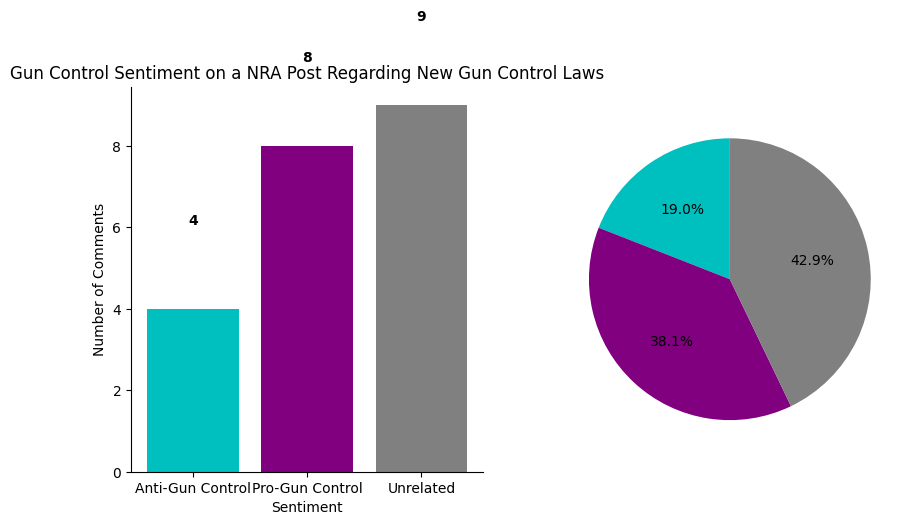

In [8]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

color=["c", "purple", "gray"]
values = [torch.sum(probs == 0), torch.sum(probs == 1), torch.sum(probs == 2)]
ax1.bar(["Anti-Gun Control", "Pro-Gun Control", "Unrelated"], values, color=color)
ax1.set_title("Gun Control Sentiment on a NRA Post Regarding New Gun Control Laws")
ax1.set_ylabel("Number of Comments")
ax1.set_xlabel("Sentiment")
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
for i, v in enumerate(values):
    ax1.text(i, v + 2, int(v), ha='center', va='bottom', fontweight='bold')





# Create a pie chart

ax2.pie(values, colors=color, autopct='%1.1f%%', startangle=90)

# Display the pie chart
plt.show()
fig.savefig('parkland_nra.png')



In [18]:
import gc
torch.cuda.empty_cache()
gc.collect()

3273